## A Brief Demo using Open Bandit Dataset and Pipeline

1. Data Loading and Preprocessing (Random Bucket of Open Bandit Dataset)
2. Off-Policy Learning (train `IPWLearner` and `NNPolicyLearner` on the training set of logged bandit data)
3. Off-Policy Evaluation (compare `IPWLearner` vs `NNPolicyLearner` on the validation set of logged bandit data)

### "What is the best new policy for the ZOZOTOWN recommendation interface?"

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import obp
from obp.dataset import OpenBanditDataset
from obp.policy import IPWLearner, NNPolicyLearner
from obp.ope import (
    RegressionModel,
    OffPolicyEvaluation,
    SelfNormalizedInverseProbabilityWeighting as SNIPS,
    DoublyRobust as DR,
)

In [2]:
print(obp.__version__)

0.5.4


## (1) Data Loading and Preprocessing

Here we use a random bucket of the Open Bandit Pipeline. We can download this by using `obp.dataset.OpenBanditDataset`.

In [3]:
# define OpenBanditDataset class to handle the real bandit data
dataset = OpenBanditDataset(
    behavior_policy="random", campaign="all", data_path="./open_bandit_dataset",
)

In [4]:
# logged bandit data collected by the uniform random policy
training_bandit_data, test_bandit_data = dataset.obtain_batch_bandit_feedback(
    test_size=0.3, is_timeseries_split=True,
)

In [5]:
# ignore the position effect for this demo purpose
training_bandit_data["position"] = None 
test_bandit_data["position"] = None

In [6]:
# number of actions
dataset.n_actions

80

In [7]:
# sample size
dataset.n_rounds

1374327

## (2) Off-Policy Learning (OPL)

Train two new policies: `obp.policy.IPWLearner` and `obp.policy.NNPolicyLearner`.

### IPWLearner

In [8]:
ipw_learner = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=RandomForestClassifier(
        n_estimators=100, max_depth=5, min_samples_leaf=10, random_state=12345
    ),
)

In [9]:
# fit
ipw_learner.fit(
    context=training_bandit_data["context"], # context; x
    action=training_bandit_data["action"], # action; a
    reward=training_bandit_data["reward"], # reward; r
    pscore=training_bandit_data["pscore"], # propensity score; pi_0(a|x)
)

In [10]:
# predict (make decisions on the test set)
action_dist_ipw = ipw_learner.predict(
    context=test_bandit_data["context"]
)

### NNPolicyLearner

In [11]:
nn_learner = NNPolicyLearner(
    n_actions=dataset.n_actions,
    dim_context=dataset.dim_context,
    solver="adam",
    off_policy_objective="ipw", # = ips
    batch_size=32, 
    random_state=12345,
)

In [12]:
# fit
nn_learner.fit(
    context=training_bandit_data["context"], # context; x
    action=training_bandit_data["action"], # action; a
    reward=training_bandit_data["reward"], # reward; r
    pscore=training_bandit_data["pscore"], # propensity score; pi_0(a|x)
)

policy learning: 100%|██████████| 200/200 [00:12<00:00, 15.65it/s]


In [13]:
# predict (make decisions on the test set)
action_dist_nn = nn_learner.predict(
    context=test_bandit_data["context"]
)

## (3) Off-Policy Evaluation

Estimate the performance of `IPWLearner` and `NNPolicyLearner` via OPE.

### (3-1) obtain a reward estimator
`obp.ope.RegressionModel` simplifies the process of reward modeling

$r(x,a) = \mathbb{E} [r \mid x, a] \approx \hat{r}(x,a)$

In [14]:
regression_model = RegressionModel(
    n_actions=dataset.n_actions, 
    base_model=LogisticRegression(C=100, max_iter=500, random_state=12345),
)

In [15]:
estimated_rewards = regression_model.fit_predict(
    context=test_bandit_data["context"], 
    action=test_bandit_data["action"], 
    reward=test_bandit_data["reward"], 
    random_state=12345,
)

### (4-2) OPE
`obp.ope.OffPolicyEvaluation` simplifies the OPE process

$V(\pi_e) \approx \hat{V} (\pi_e; \mathcal{D}_0, \theta)$

Here we use SNIPS and DR

In [16]:
ope = OffPolicyEvaluation(
    bandit_feedback=test_bandit_data,
    ope_estimators=[
        SNIPS(estimator_name="SNIPS"),
        DR(estimator_name="DR"),
    ]
)

### (4-3) Visualize the OPE results

Visualize the relative performances of the trained policies compared to the logging policy (uniform random)

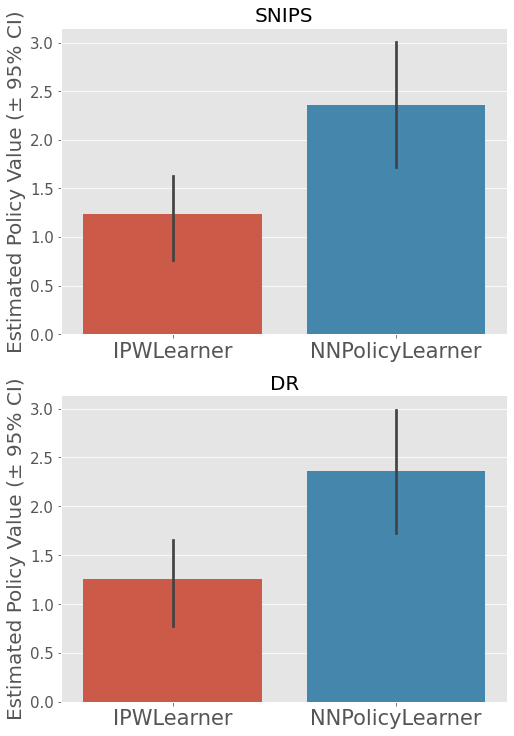

In [17]:
ope.visualize_off_policy_estimates_of_multiple_policies(
    policy_name_list=["IPWLearner", "NNPolicyLearner"],
    action_dist_list=[action_dist_ipw, action_dist_nn],
    estimated_rewards_by_reg_model=estimated_rewards,
    n_bootstrap_samples=100,
    is_relative=True,
    random_state=12345,
)

Both policy learners outperform the random baseline. In particular, NNPolicyLearner seems to be the best, improving the random baseline by about 70\% (in terms of the estimated lower confidence bound). It also outperforms IPWLearner wrt both SNIPS and DR estimates.